#Introduction

#Libraries

Here all required librares are imported

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import cv2 # computer vision cv2
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import transform
from skimage.feature import hog
from skimage import data,exposure
from sklearn.datasets import make_multilabel_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix
import time
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

#Dataset

**Dataset contain 360 images for traing and 40 images for testing.** 

There are 6 classes present in dataset which are enlisted following

1) blue helmet

2) person

3) red helmet

4) vest

5) white helmet

6) yellow helmet

**Data pre-processing**

However for data pre-processing all images are zero mean normalized and resized to 224x200

In [2]:
x_train = []
x_test=[]
train = os.listdir('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/train/')
test = os.listdir('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/test/')
for file in tqdm(train):
    img = cv2.imread('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/train/' + file)
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img_rgb, (224, 200))
    image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
    x_train.append(image_norm)
for file in tqdm(test):
    img = cv2.imread('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/test/' + file)
    img_rgb=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img_rgb, (224, 200))
    image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
    x_test.append(image_norm)

100%|██████████| 40/40 [00:07<00:00,  5.07it/s]


In [3]:
train_df=pd.read_csv('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/train_labels.csv')
test_df=pd.read_csv('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/test_labels.csv')
y_train=train_df.iloc[:,1:].to_numpy()
y_test=test_df.iloc[:,1:].to_numpy()

In [12]:
print("SUMMARY OF DATA:")

print("train_x shape: " + str(np.shape(x_train)))
print("train_y shape: " + str(np.shape(y_train)))
print("test_x shape: " + str(np.shape(x_test)))
print("test_y shape: " + str(np.shape(y_test)))

SUMMARY OF DATA:
train_x shape: (360, 200, 224, 3)
train_y shape: (360, 6)
test_x shape: (40, 200, 224, 3)
test_y shape: (40, 6)


**A sample training image is shown below.**

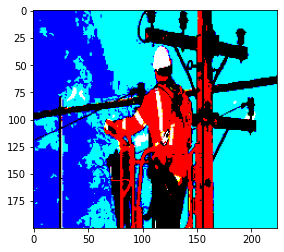

In [11]:
index = 5
plt.imshow((x_train[index]*255),cmap='gray')
plt.show()

#Image Classification Using Harris Feature Extraction and SVM

**Feature Extraction Using Harris Features**
* Harris Corner Detector is a corner detection operator that is commonly used in computer vision algorithms to extract corners and infer features of an image.

In [13]:
def get_harris(image):
    clr=image
    gray=cv2.cvtColor(clr,cv2.COLOR_RGB2GRAY)
    gray_img = np.float32(gray)#STEP3: IT IS A IMPORTANT STEP WHERE WE ARE CONVERTING THE GRAY SCALED IMAGE IN FLOATING TYPE
    # 1ST ARGUMENT: Input Image,
    # 2ND ARGUMENT: Neighborhood size,
    # 3RD ARGUMENT: Aperture parameter for the Sobel() operator
    # 4TH ARGUMENT: VALUE OF 'k'
    dst = cv2.cornerHarris(gray_img,3,5,0.08)
    dst = cv2.dilate(dst,None)
    clr[dst>0.05*dst.max()] = [255,0,0]
    return(clr)

In [14]:
htrain=[]
for file in tqdm(x_train):
  features=get_harris(file)
  htrain.append(features)
htest=[]
for file in tqdm(x_test):
  features=get_harris(file)
  htest.append(features)

100%|██████████| 40/40 [00:00<00:00, 525.88it/s]


In [15]:
htrain=np.array(htrain)
htest=np.array(htest)
print(np.shape(htrain),np.shape(htest))

(360, 200, 224, 3) (40, 200, 224, 3)


Getting the Harris features which were previously generated on the Train and test data

(200, 224, 3)


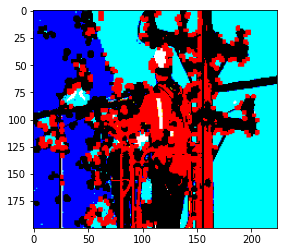

In [16]:
b=get_harris(x_train[5]*255)
plt.imshow(b)
print(b.shape)

In [17]:
h_train=htrain.reshape(360, -1)
h_test=htest.reshape(40, -1)

In [18]:
np.shape(h_train)

(360, 134400)

In [19]:
classifier = OneVsRestClassifier(SVC(kernel="linear"))
classifier.fit(h_train, y_train)


OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [21]:
y_pred = classifier.predict(h_test)
#print(y_pred)

In [27]:
scores=classifier.score(h_train,y_train)
print('training accuracy of classifier is '+str((scores)*10))

training accuracy of classifier is1.0


In [30]:
scores=classifier.score(h_test,y_test)
print('testing accuracy of classifier is '+str((scores)*100))

testing accuracy of classifier is 10.0


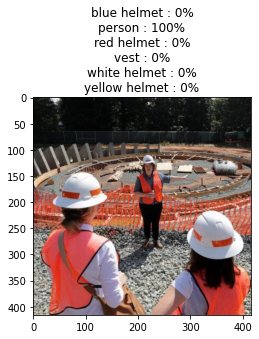

In [26]:

img_r = cv2.imread('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/test/ppe_0004_jpg.rf.d183e99cb02913336c66845484c24898.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img_rgb, (224, 200))
image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
harris = get_harris(image_norm)
h_harris=harris.reshape(1, -1)
#img = np.expand_dims(h_harris, axis=0)
r=classifier.predict(h_harris)

#names= dict((v,k) for k,v in labels.items())
#index = np.argmax(r)
#name=names.get(index,"Unknown")
p=round(r.max()*100, 3)  #to find maximum score

scores=r
#print(scores)


#plt.rc('font', **font)
names=['blue helmet',	'person',	'red helmet',	'vest'	,'white helmet',	'yellow helmet']
#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" : "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" : "+ str(round(scores[0][1]*100,1))+"%"+"\n"
+names[2] +" : "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" : "+ str(round(scores[0][3]*100,1))+"%"+"\n"+names[4] +" : "+ str(round(scores[0][4]*100,1))+"%"+"\n"
+names[5] +" : "+ str(round(scores[0][0]*100,1))+"%")

plt.imshow(img_rgb)

#Image Classification Using HOG Feature Extraction and SVM

**Feature Extraction Using HOG Features**
* The histogram of oriented gradients (HOG) is a feature descriptor used in computer vision and image processing for the purpose of object detection. The technique counts occurrences of gradient orientation in localized portions of an image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


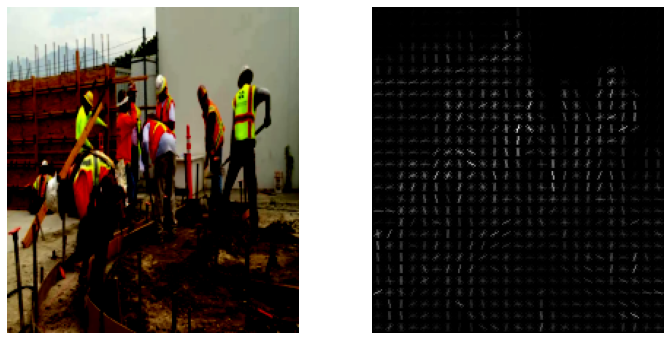

In [45]:
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img2 = transform.resize(img_rgb, (224, 200))
image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
hog_features,visualized = hog(image_norm,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6),
                              visualize=True,
                              multichannel=True
                             )# fd= feature descriptor

fig = plt.figure(figsize=(12,6))
fig.add_subplot(1,2,1)
plt.imshow(image_norm)
plt.axis("off")
fig.add_subplot(1,2,2)
plt.imshow(visualized,cmap="gray")
plt.axis("off")
plt.show()

In [31]:
def get_hog(image):
    hog_features,visualized = hog(image,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6),
                              visualize=True,
                              multichannel=True
                             )
    return(hog_features)

In [35]:
hog_train=[]
for file in tqdm(x_train):
  features=get_hog(file)
  hog_train.append(features)
hog_test=[]
for file in tqdm(x_test):
  features=get_hog(file)
  hog_test.append(features)

100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


In [36]:
print('shape of x_train is '+str(np.shape(hog_train)))
print('shape of y_train is '+str(np.shape(y_train)))
print('shape of x_test is '+str(np.shape(hog_test)))
print('shape of y_test is '+str(np.shape(y_test)))

shape of x_train is (360, 149040)
shape of y_train is (360, 6)
shape of x_test is (40, 149040)
shape of y_test is (40, 6)


In [114]:
HOG = OneVsRestClassifier(SVC(kernel="linear"))
HOG.fit(hog_train, y_train)


OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [40]:
y_pred = HOG.predict(hog_test)
#print(y_pred

In [42]:
scores=HOG.score(hog_train,y_train)
print('training accuracy of classifier is '+str((scores)*10))

training accuracy of classifier is 10.0


In [43]:
scores=HOG.score(hog_test,y_test)
print('testing accuracy of classifier is '+str((scores)*100))

testing accuracy of classifier is 7.5


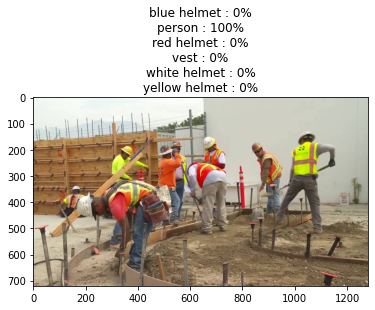

In [44]:

img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img2 = transform.resize(img_rgb, (224, 200))
image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
hog_features,visualized = hog(image_norm,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6),
                              visualize=True,
                              multichannel=True
                             )# fd= feature descriptor
img = np.expand_dims(hog_features, axis=0)
r= HOG.predict(img)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
#print(scores)


#plt.rc('font', **font)
names=['blue helmet',	'person',	'red helmet',	'vest'	,'white helmet',	'yellow helmet']
#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" : "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" : "+ str(round(scores[0][1]*100,1))+"%"+"\n"
+names[2] +" : "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" : "+ str(round(scores[0][3]*100,1))+"%"+"\n"+names[4] +" : "+ str(round(scores[0][4]*100,1))+"%"+"\n"
+names[5] +" : "+ str(round(scores[0][0]*100,1))+"%")

plt.imshow(img_rgb)

#Image Classification Using HOG Feature Extraction, PCA and SVM

**Feature Selection Using PCA**

* Sklearn has an inbuilt module which transforms the given data set into the required number of components.
* We are resolving the HOG feature vector into 30 components from an initial feature vector length of 1764 values.
* Classification is done using an SVM classifier using rbf kernel

In [109]:
pca = PCA(n_components=30)
x_train_hog=np.array(hog_train)
htrain_pca = pca.fit_transform(x_train_hog)

In [110]:
pca = PCA(n_components=30)
x_test_hog=np.array(hog_test)
htest_pca = pca.fit_transform(x_test_hog)

In [112]:
print('shape of x_train is '+str(np.shape(hog_train)))
print('shape of x_test is '+str(np.shape(hog_test)))
print('shape of y_train is '+str(np.shape(y_train)))
print('shape of y_test is '+str(np.shape(y_test)))
print('shape of x_train after PCA is '+str(np.shape(htrain_pca)))
print('shape of x_test after PCA is '+str(np.shape(htest_pca)))

shape of x_train is (360, 149040)
shape of x_test is (40, 149040)
shape of y_train is (360, 6)
shape of y_test is (40, 6)
shape of x_train after PCA is (360, 30)
shape of x_test after PCA is (40, 30)


In [103]:
HOG_pca = OneVsRestClassifier(SVC(kernel="linear"))
HOG_pca.fit(htrain_pca, y_train)


OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [100]:
y_pred = HOG_pca.predict(htest_pca)
#print(y_pred

In [101]:
scores=HOG_pca.score(htrain_pca,y_train)
print('training accuracy of classifier is '+str((scores)*100))

training accuracy of classifier is 19.72222222222222


In [113]:
scores=HOG_pca.score(htest_pca,y_test)
print('testing accuracy of classifier is '+str((scores)*100))

testing accuracy of classifier is 7.5


(30, 4968)


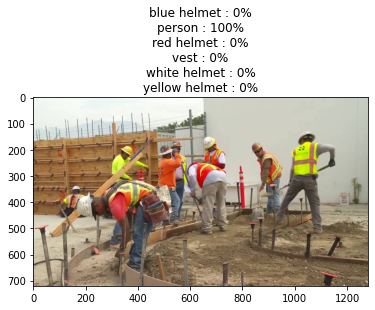

In [55]:
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img2 = transform.resize(img_rgb, (224, 200))
image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
hog_features,visualized = hog(image_norm,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6),
                              visualize=True,
                              multichannel=True
                             )# fd= feature descriptor
x_pred_hog=np.array(hog_features)
x_pred_hog=x_pred_hog.reshape(30,-1)
print(x_pred_hog.shape)
pca = PCA(n_components=30,svd_solver='full')
htest_pca = pca.fit_transform(x_pred_hog)
#img = np.expand_dims(htest_pca axis=0)
r= HOG.predict(htest_pca)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
#print(scores)


#plt.rc('font', **font)
names=['blue helmet',	'person',	'red helmet',	'vest'	,'white helmet',	'yellow helmet']
#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" : "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" : "+ str(round(scores[0][1]*100,1))+"%"+"\n"
+names[2] +" : "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" : "+ str(round(scores[0][3]*100,1))+"%"+"\n"+names[4] +" : "+ str(round(scores[0][4]*100,1))+"%"+"\n"
+names[5] +" : "+ str(round(scores[0][0]*100,1))+"%")

plt.imshow(img_rgb)

#Image Classification Using CNN(VGG16) Feature Extraction and SVM

**Feature Extraction Using CNN Architecture(VGG16)**
* VGG16 is a convolution neural net (CNN ) architecture that is commonly used in deep learning algorithms to extract features of an image.

In [56]:
x_train_cnn=np.array(x_train)
x_test_cnn=np.array(x_test)

In [58]:
print('shape of x_train is '+str(np.shape(x_train_cnn)))
print('shape of y_train is '+str(np.shape(y_train)))
print('shape of x_test is '+str(np.shape(x_test_cnn)))
print('shape of y_test is '+str(np.shape(y_test)))

shape of x_train is (360, 200, 224, 3)
shape of y_train is (360, 6)
shape of x_test is (40, 200, 224, 3)
shape of y_test is (40, 6)


In [61]:
from tensorflow.keras.applications.vgg16 import VGG16
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(200,224,3))
for layer in VGG_Model.layers:
    layer.trainable=False
VGG_Model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 56, 128)       0     

In [62]:
feature_extractor=VGG_Model.predict(x_train_cnn)
train_feature_cnn=feature_extractor.reshape(360,-1)

In [63]:
test_feature_extractor=VGG_Model.predict(x_test_cnn)
test_feature_cnn=test_feature_extractor.reshape(40,-1)

In [64]:
print(np.shape(train_feature_cnn))
print(np.shape(test_feature_cnn))

(360, 21504)
(40, 21504)


In [65]:
CNN = OneVsRestClassifier(SVC(kernel="linear"))
CNN.fit(train_feature_cnn, y_train)


OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [66]:
y_pred = CNN.predict(test_feature_cnn)
#print(y_pred

In [68]:
scores=CNN.score(train_feature_cnn,y_train)
print('training accuracy of classifier is '+str((scores)*100))

training accuracy of classifier is 100.0


In [69]:
scores=CNN.score(test_feature_cnn,y_test)
print('testing accuracy of classifier is '+str((scores)*100))

testing accuracy of classifier is 17.5


(1, 200, 224, 3)


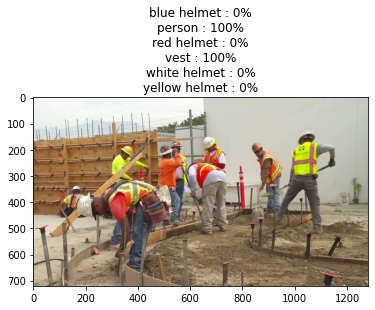

In [71]:
import cv2
from skimage import transform
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img2 = transform.resize(img_rgb, (200, 224))
image_norm = cv2.normalize(img2, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
pred_img=np.array(image_norm)
img = np.expand_dims(pred_img, axis=0)
print(img.shape)
f=VGG_Model.predict(img)
reshape=f.reshape(1,-1)
#img = np.expand_dims(image_norm, axis=0)
r= CNN.predict(reshape)

p=round(r.max()*100, 3)  #to find maximum score

scores=r
#print(scores)


#plt.rc('font', **font)
names=['blue helmet',	'person',	'red helmet',	'vest'	,'white helmet',	'yellow helmet']
#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" : "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" : "+ str(round(scores[0][1]*100,1))+"%"+"\n"
+names[2] +" : "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" : "+ str(round(scores[0][3]*100,1))+"%"+"\n"+names[4] +" : "+ str(round(scores[0][4]*100,1))+"%"+"\n"
+names[5] +" : "+ str(round(scores[0][0]*100,1))+"%")

plt.imshow(img_rgb)

#Image Classification Using CNN

**Feature Extraction Using CNN Architecture(VGG16)**
* VGG16 is a convolution neural net (CNN ) architecture that is commonly used in deep learning algorithms to extract features of an image.

In [72]:
x_train_cn=np.array(x_train)
x_test_cn=np.array(x_test)

In [73]:
print('shape of x_train is '+str(np.shape(x_train_cn)))
print('shape of y_train is '+str(np.shape(y_train)))
print('shape of x_test is '+str(np.shape(x_test_cn)))
print('shape of y_test is '+str(np.shape(y_test)))

shape of x_train is (360, 200, 224, 3)
shape of y_train is (360, 6)
shape of x_test is (40, 200, 224, 3)
shape of y_test is (40, 6)


In [74]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import BatchNormalization,Dropout,Flatten,Dense,Input,Conv2D
from tensorflow.keras import layers  

In [75]:
def build_model():
    model1 = Sequential()
    model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(200,224,3)))
    model1.add(layers.MaxPooling2D((2, 2)))
    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.MaxPooling2D((2, 2)))
    model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model1.add(layers.Flatten())
    model1.add(Dense(32, activation='relu',input_dim=htrain_pca.shape[1],kernel_initializer='he_uniform'))
    model1.add(Dropout(0.4))
    model1.add(Dense(64, activation='relu'))
    #x=BatchNormalization()(x)
    model1.add(Dropout(0.5))
    model1.add(Dense(16, activation='relu'))
    #x=BatchNormalization()(x)
    model1.add(Dropout(0.5))
    # muti-class Classification
    model1.add(Dense(units = 6, activation='sigmoid'))
    optimizers = Adam()
    
    model1.compile(loss = 'binary_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

    return model1
cnn_model=build_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 111, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 109, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 153088)            0

In [77]:
from keras import callbacks
filepath = '/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/Weights/Helment-detection-CNN.hdf5'
checkpoint = callbacks.ModelCheckpoint( filepath, monitor = 'loss', save_best_only = True, 
                                       mode = 'min', verbose = 1)
callbacks_list = [checkpoint]
import datetime
import keras

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(logdir)

In [79]:
history = cnn_model.fit(x_train_cn,y_train, epochs=30,
                              callbacks = [tensorboard_callback, checkpoint] )

Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 3.3571 - accuracy: 0.5528
Epoch 1: loss improved from inf to 3.35712, saving model to /content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/Weights/Helment-detection-CNN.hdf5
12/12 [==============================] - 8s 337ms/step - loss: 3.3571 - accuracy: 0.5528
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.8028
Epoch 2: loss improved from 3.35712 to 0.70699, saving model to /content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/Weights/Helment-detection-CNN.hdf5
12/12 [==============================] - 1s 64ms/step - loss: 0.7070 - accuracy: 0.8028
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.6831 - accuracy: 0.8381
Epoch 3: loss improved from 0.70699 to 0.68311, saving model to /content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/Weights/Helment-detection-CNN.hdf5
12/12 [==============================] - 1s 62ms/step - loss: 0.6831 - 

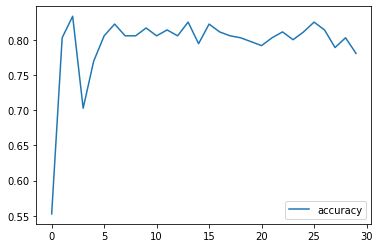

In [80]:
pd.DataFrame(history.history)[['accuracy']].plot()


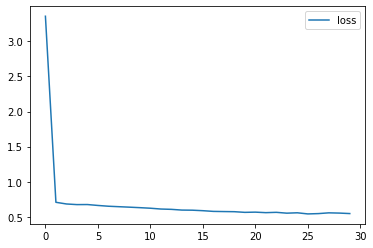

In [81]:
pd.DataFrame(history.history)[['loss']].plot()

In [82]:
cnn_model.evaluate(x_test_cn,y_test)

2/2 [==============================] - 0s 10ms/step - loss: 0.5353 - accuracy: 0.8750


[0.5353173017501831, 0.875]

In [83]:
cnn_model.load_weights('/content/drive/MyDrive/Helments and Vests.v1-v1.multiclass/Weights/Helment-detection-CNN.hdf5')

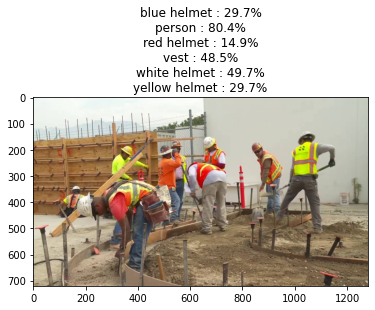

In [84]:
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img_rr=cv2.resize(img_rgb,(224,200))

img = np.expand_dims(img_rr, axis=0)
r=cnn_model.predict(img)

#names= dict((v,k) for k,v in labels.items())
#index = np.argmax(r)
#name=names.get(index,"Unknown")
p=round(r.max()*100, 3)  #to find maximum score

scores=r
#print(scores)


#plt.rc('font', **font)
names=['blue helmet',	'person',	'red helmet',	'vest'	,'white helmet',	'yellow helmet']
#plt.title(name +" ("+ str(p)+")")
plt.title(names[0] +" : "+ str(round(scores[0][0]*100,1))+"%"+"\n"+names[1] +" : "+ str(round(scores[0][1]*100,1))+"%"+"\n"
+names[2] +" : "+ str(round(scores[0][2]*100,1))+"%"+"\n"+names[3] +" : "+ str(round(scores[0][3]*100,1))+"%"+"\n"+names[4] +" : "+ str(round(scores[0][4]*100,1))+"%"+"\n"
+names[5] +" : "+ str(round(scores[0][0]*100,1))+"%")

plt.imshow(img_rgb)

#Image Detection Using Harris Feature Extraction and SVM

In [85]:
def slideExtract(image,windowSize=(224,200),step=20):
    
    # # Converting to grayscale
    # if channel == "RGB":
    #     img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # elif channel == "BGR":
    #     img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # elif channel.lower()!="grayscale" or channel.lower()!="gray":
    #     raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = image[h1:h2,w1:w2]
            window_norm = cv2.normalize(window, None, alpha=-1,beta=1, norm_type=cv2.NORM_MINMAX)
            harris = get_harris(window_norm)
            h_harris=harris.reshape( -1)
            features.append(h_harris)
            
            coords.append((w1,w2,h1,h2))
            #features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [86]:
#example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg"))
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0010.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img_g=cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
#img2 = cv2.resize(img_rgb, (224, 224))
coords,features = slideExtract(img_rgb)

print(coords)

[(0, 224, 0, 200), (20, 244, 0, 200), (40, 264, 0, 200), (60, 284, 0, 200)]


In [87]:


class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [88]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = classifier.predict([features[i]])
        #print(decision)
        if decision[0][1] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

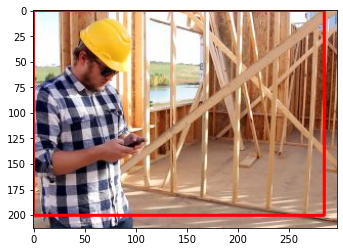

In [89]:
detected = detect(img_rgb)
plt.imshow(detected)

#Image Detection Using HOG Feature Extraction and SVM

In [90]:
def slideExtract(image,windowSize=(224,200),step=20):
    
    # # Converting to grayscale
    # if channel == "RGB":
    #     img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # elif channel == "BGR":
    #     img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # elif channel.lower()!="grayscale" or channel.lower()!="gray":
    #     raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = image[h1:h2,w1:w2]
            #print(window)
            features_of_window = hog(window,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [91]:
#example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg"))
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0010.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img_g=cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
#img2 = cv2.resize(example_image, (224, 224))
coords,features = slideExtract(img_rgb)

print(coords)

[(0, 224, 0, 200), (20, 244, 0, 200), (40, 264, 0, 200), (60, 284, 0, 200)]


In [92]:
from sklearn.preprocessing import MinMaxScaler

class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [115]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = HOG.predict([features[i]])
        #print(decision)
    #for j in range(0,i):
    if decision[0][1] == 1:
        htmp.incValOfReg(coords[i])
            # Else remove some heat
    else:
        htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

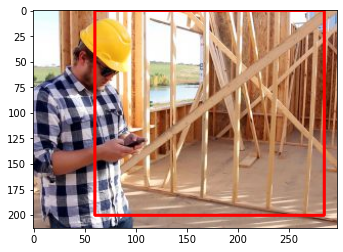

In [116]:
detected = detect(img_rgb)
plt.imshow(detected)

#Image Detection Using HOG Feature Extraction, PCA and SVM

In [117]:
def slideExtract(image,windowSize=(224,200),step=20):
    
    # # Converting to grayscale
    # if channel == "RGB":
    #     img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    # elif channel == "BGR":
    #     img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    # elif channel.lower()!="grayscale" or channel.lower()!="gray":
    #     raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = image[h1:h2,w1:w2]
            #print(window)
            features_of_window = hog(window,orientations=9,pixels_per_cell=(8,8),
                              cells_per_block=(6,6)
                                    )
            
            coords.append((w1,w2,h1,h2))
            features.append(features_of_window)
    
    return (coords,np.asarray(features))

In [118]:
#example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg"))
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0010.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
img_g=cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
#img2 = cv2.resize(example_image, (224, 224))
coords,features = slideExtract(img_rgb)

print(coords)

[(0, 224, 0, 200), (20, 244, 0, 200), (40, 264, 0, 200), (60, 284, 0, 200)]


In [119]:
features=np.array(features)
print(features.shape)
features_hog=features.reshape(30,-1)
print(features_hog.shape)
pca = PCA(n_components=30)
features_pca = pca.fit_transform(features_hog)
print(features_pca.shape)

(4, 149040)
(30, 19872)
(30, 30)


In [120]:

print(np.shape(x_train_hog))
print(features_pca.shape)

(360, 149040)
(30, 30)


In [121]:
class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [124]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = HOG_pca.predict([features_pca[i]])
        #print(decision)
    #for j in range(0,i):
    if decision[0][1] == 1:
        htmp.incValOfReg(coords[i])
            # Else remove some heat
    else:
        htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

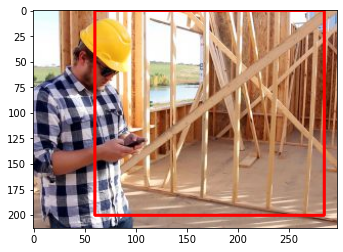

In [125]:
detected = detect(img_rgb)
plt.imshow(detected)

#Image Detection using CNN(VGG16) Feature Extraction and SVM

In [145]:
def slideExtract(image,windowSize=(224,200),channel ="RGB",step=25):
    
    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            window=np.array(window)
            #print(window.shape)
            #window=np.transpose(window)
            #print(window.shape)
            window2=cv2.cvtColor(window,cv2.COLOR_GRAY2RGB)
            #print(window2.shape)
            window3=np.expand_dims(window2, axis=0)
            #print(window3.shape)
            features_of_window = VGG_Model.predict(window3)
            features_of_window=np.array(features_of_window)
            features_w=features_of_window.reshape(-1)
            
            coords.append((w1,w2,h1,h2))
            features.append(features_w)
    
    return (coords,np.asarray(features))

In [146]:
#example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg"))
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0010.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
#img_g=cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
#img2 = cv2.resize(img_rgb, (200, 224))
coords,features = slideExtract(img_rgb,channel = "RGB")

print(coords)

[(0, 224, 0, 200), (25, 249, 0, 200), (50, 274, 0, 200)]


In [147]:

print(np.shape(train_feature_cnn))
print(features.shape)

(360, 21504)
(3, 21504)


In [148]:
class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [153]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = CNN.predict([features[i]])
        #print(decision)
        if decision[0][1] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

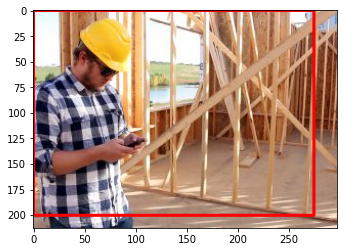

In [154]:
detected = detect(img_rgb)
plt.imshow(detected)

#Image Detection using CNN

In [173]:
def slideExtract(image,windowSize=(200,224),channel ="RGB",step=200):
    
    # Converting to grayscale
    if channel == "RGB":
        img = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    elif channel == "BGR":
        img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    elif channel.lower()!="grayscale" or channel.lower()!="gray":
        raise Exception("Invalid channel type")
    
    # We'll store coords and features in these lists
    coords = []
    features = []
    
    hIm,wIm = image.shape[:2] 

    
    # W1 will start from 0 to end of image - window size
    # W2 will start from window size to end of image
    # We'll use step (stride) like convolution kernels.
    for w1,w2 in zip(range(0,wIm-windowSize[0],step),range(windowSize[0],wIm,step)):
       
        for h1,h2 in zip(range(0,hIm-windowSize[1],step),range(windowSize[1],hIm,step)):
            window = img[h1:h2,w1:w2]
            t=np.transpose(window)
            im=cv2.cvtColor(t,cv2.COLOR_GRAY2RGB)
            im=np.array(im)
            # #print(window.shape)
            #window=np.transpose(window)
            # #print(window.shape)
            # window2=cv2.cvtColor(window,cv2.COLOR_GRAY2RGB)
            # #print(window2.shape)
            # window3=np.expand_dims(window2, axis=0)
            # #print(window3.shape)
            # features_of_window = cnn_model.predict(window3)
            # features_of_window=np.array(features_of_window)
            # features_w=features_of_window.reshape(-1)
            
            coords.append((w1,w2,h1,h2))
            features.append(im)
    
    return (coords,np.asarray(features))

In [179]:
#example_image = np.asarray(PIL.Image.open("/content/drive/MyDrive/customTF/data/images/ppe_0100.jpg"))
img_r = cv2.imread('/content/drive/MyDrive/customTF/data/images/ppe_0070.jpg')
img_rgb=cv2.cvtColor(img_r,cv2.COLOR_BGR2RGB)
#img_g=cv2.cvtColor(img_r,cv2.COLOR_BGR2GRAY)
#img2 = transform.resize(img_rgb, (224, 224))
coords,features = slideExtract(img_rgb,channel = "RGB")

print(coords)

[(0, 200, 0, 224), (0, 200, 200, 424), (0, 200, 400, 624), (200, 400, 0, 224), (200, 400, 200, 424), (200, 400, 400, 624)]


In [180]:

print(np.shape(x_train_cn))
print(features.shape)

(360, 200, 224, 3)
(6, 200, 224, 3)


In [181]:
class Heatmap():
    
    def __init__(self,original_image):
        
        # Mask attribute is the heatmap initialized with zeros
        self.mask = np.zeros(original_image.shape[:2])
    
    # Increase value of region function will add some heat to heatmap
    def incValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] + 30
    
    # Decrease value of region function will remove some heat from heatmap
    # We'll use this function if a region considered negative
    def decValOfReg(self,coords):
        w1,w2,h1,h2 = coords
        self.mask[h1:h2,w1:w2] = self.mask[h1:h2,w1:w2] - 30
    
    def compileHeatmap(self):
        
        # As you know,pixel values must be between 0 and 255 (uint8)
        # Now we'll scale our values between 0 and 255 and convert it to uint8
        
        # Scaling between 0 and 1 
        scaler = MinMaxScaler()
        
        self.mask = scaler.fit_transform(self.mask)
        
        
        # Scaling between 0 and 255
        self.mask = np.asarray(self.mask * 255).astype(np.uint8)
        
        # Now we'll threshold our mask, if a value is higher than 170, it will be white else
        # it will be black
        self.mask = cv2.inRange(self.mask,170,255)
        
        return self.mask

In [182]:
def detect(image):
    
    # Extracting features and initalizing heatmap
    coords,features = slideExtract(image)
    htmp = Heatmap(image)
    
    
    for i in range(len(features)):
        # If region is positive then add some heat
        decision = cnn_model.predict(np.array([features[i]]))
        #print(decision)
        if decision[0][1] == 1:
            htmp.incValOfReg(coords[i])
            # Else remove some heat
        else:
            htmp.decValOfReg(coords[i])
    
    # Compiling heatmap
    mask = htmp.compileHeatmap()
    
    cont,_ = cv2.findContours(mask,1,2)[:2]
    for c in cont:
        # If a contour is small don't consider it
        if cv2.contourArea(c) < 70*70:
            continue
        
        (x,y,w,h) = cv2.boundingRect(c)
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255),2)
    
    return image

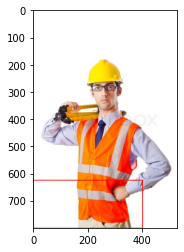

In [183]:
detected = detect(img_rgb)
plt.imshow(detected)

#Results

Accuracy of Each Model is calculated and shown in bar graph

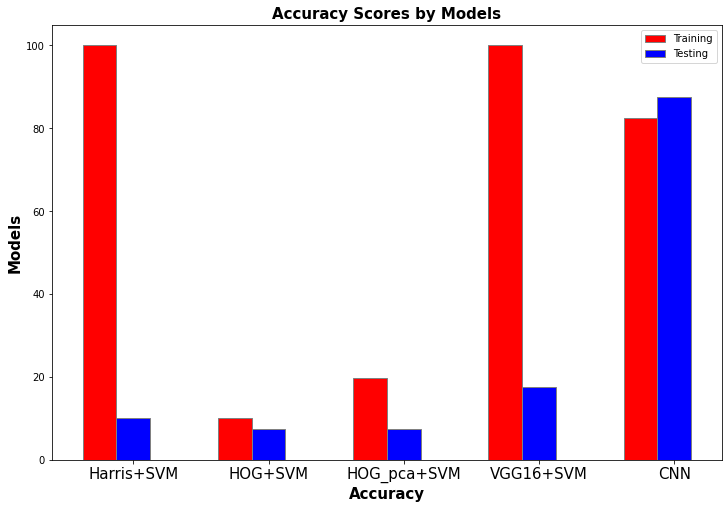

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
tr = [100,10,19.72,100,82.5]
ts = [10,7.5,7.5,17.5,87.5]

# Set position of bar on X axis
br1 = np.arange(len(tr))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, tr, color ='r', width = barWidth,
		edgecolor ='grey', label ='Training')
plt.bar(br2, ts, color ='b', width = barWidth,
		edgecolor ='grey', label ='Testing')

# Adding Xticks
plt.xlabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.ylabel('Models', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(ts))],
		['Harris+SVM', 'HOG+SVM','HOG_pca+SVM', 'VGG16+SVM', 'CNN'], fontsize = 15)
plt.title('Accuracy Scores by Models',fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()
